In [9]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

def preprocess_data(file_path):
    # Load data from CSV
    df = pd.read_csv(file_path)
    
    # Fill missing ages with the median age
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Fill missing Embarked values with the mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Create a new feature for FamilySize (including the passenger)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # Categorize FamilySize into groups (Alone, Small, Large)
    df["FamilyGroup"] = pd.cut(
        df["FamilySize"],
        bins=[0, 1, 4, np.inf],
        labels=["Alone", "Small", "Large"]
    )
    
    # Create a binary feature where 1 indicates the passenger is alone
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    
    # Combine Pclass and FamilySize to capture potential interaction effects
    df["Pclass_FamilySize"] = df["Pclass"] * df["FamilySize"]
    
    # Extract titles from the Name using a regular expression
    df["Title"] = df["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)
    
    # Replace some of the less common or similar titles
    df["Title"] = df["Title"].replace(["Rev", "Dr", "Col", "Major"], "Rare")
    df["Title"] = df["Title"].replace(["Mlle", "Ms"], "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")
    
    # Map the titles to numerical values
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df["Title"] = df["Title"].map(title_mapping)
    
    # Convert Sex into a binary variable: 0 for male and 1 for female
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    
    # One-hot encode the Embarked column
    df = pd.get_dummies(df, columns=["Embarked"], prefix="Embarked")
    
    return df

In [10]:
df_train = preprocess_data('train.csv')
df_test = preprocess_data('test.csv')

In [11]:
features = ['Age', 'Sex', 'Fare', 'FamilySize', 'IsAlone', 'Pclass_FamilySize', 'Title']

X = df_train[features]
y = df_train['Survived'].values

X_test = df_test[features]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [12]:
# Using several depths of decision tree to predict
depths = [2, 3, 4, 5]
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    clf.fit(X, y)

    # Predict on validation set
    y_pred = clf.predict(X_val)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Print results
    print(f"\nMax Depth = {depth}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    


Max Depth = 2
  Precision: 0.7344
  Recall:    0.7231
  Accuracy:  0.8034
  F1 Score:  0.7287

Max Depth = 3
  Precision: 0.7344
  Recall:    0.7231
  Accuracy:  0.8034
  F1 Score:  0.7287

Max Depth = 4
  Precision: 0.7833
  Recall:    0.7231
  Accuracy:  0.8258
  F1 Score:  0.7520

Max Depth = 5
  Precision: 0.7778
  Recall:    0.7538
  Accuracy:  0.8315
  F1 Score:  0.7656


In [13]:
# logistic regression with L1 regularization
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression_l1(X, y, lr=0.01, epochs=1000, lambda_l1=0.1):
    m, n = X.shape
    weights = np.zeros(n)  
    bias = 0 
    
    for epoch in range(epochs):
        z = np.dot(X, weights) + bias
        predictions = sigmoid(z)
        
        error = predictions - y
        dw = (1 / m) * np.dot(X.T, error) + lambda_l1 * np.sign(weights)  # L1 gradient
        db = (1 / m) * np.sum(error)
        
        weights -= lr * dw
        bias -= lr * db

    return weights, bias

def predict(X, weights, bias):
    z = np.dot(X, weights) + bias
    probabilities = sigmoid(z)
    return np.where(probabilities >= 0.5, 1, 0)

In [14]:
df_train = preprocess_data("train.csv")

features = [
    "Pclass",
    "Sex",
    "Age",
    "Fare",
    "IsAlone",
    "Title",
    "FamilySize",
    "Embarked_C", "Embarked_Q", "Embarked_S",
    "Pclass_FamilySize"
]

X = df_train[features].values  
y = df_train["Survived"].values 


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

possible_lambdas = [0.01, 0.1, 0.5, 1.0]
possible_lrs = [0.001, 0.01, 0.1]

best_val_acc = 0.0
best_params = (None, None)
best_weights = None
best_bias = None

for lam in possible_lambdas:
    for lr in possible_lrs:
        w, b = logistic_regression_l1(
            X_train, y_train, 
            lr=lr, 
            epochs=1000, 
            lambda_l1=lam
        )

        val_pred = predict(X_val, w, b)
        val_acc = np.mean(val_pred == y_val)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (lam, lr)
            best_weights = w
            best_bias = b

print(f"Best lambda, lr: {best_params}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

test_preds = predict(X_test, best_weights, best_bias)
test_acc = np.mean(test_preds == y_test)
print(f"Test accuracy: {test_acc:.4f}")

Best lambda, lr: (0.01, 0.001)
Best validation accuracy: 0.6180
Test accuracy: 0.6145


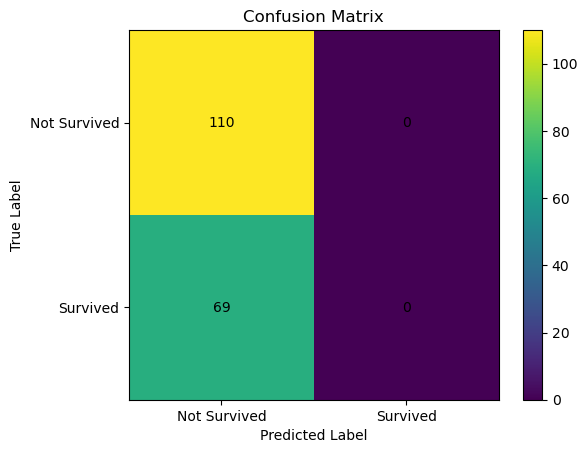

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Survived', 'Survived'])
plt.yticks(tick_marks, ['Not Survived', 'Survived'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center")

plt.show()


In [16]:
# logistic regression with l2 regularization
def logistic_regression_l2(X, y, lr=0.01, epochs=1000, lambda_l2=0.1):
    """
    Implements Logistic Regression with L2 regularization 
    using basic gradient descent.
    
    X: shape (m, n)     (We assume you've already prepended a column of 1s if you want it.)
    y: shape (m,)
    
    lr: learning rate
    epochs: number of epochs
    lambda_l2: L2 regularization parameter
    
    Returns:
       weights (1D numpy array, shape (n,))
       bias    (scalar)
    """
    m, n = X.shape
    
    weights = np.zeros(n)  
    bias = 0.0
    
    for epoch in range(epochs):
        z = np.dot(X, weights) + bias
        predictions = sigmoid(z)
        error = predictions - y   
        dw = (1 / m) * np.dot(X.T, error) + (lambda_l2 * weights) / m
        db = (1 / m) * np.sum(error)
        weights -= lr * dw
        bias -= lr * db
    
    return weights, bias

def predict(X, weights, bias):
    """Predict binary class (0 or 1) using logistic regression."""
    z = np.dot(X, weights) + bias
    probabilities = sigmoid(z)
    return np.where(probabilities >= 0.5, 1, 0)

In [17]:
lambda_l2 = 0.1
learning_rate = 0.01
epochs = 1000

weights, bias = logistic_regression_l2(
    X_train, 
    y_train, 
    lr=learning_rate, 
    epochs=epochs, 
    lambda_l2=lambda_l2
)

y_test_pred = predict(X_test, weights, bias)

accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy with L2: {accuracy:.4f}")

Test Accuracy with L2: 0.6145


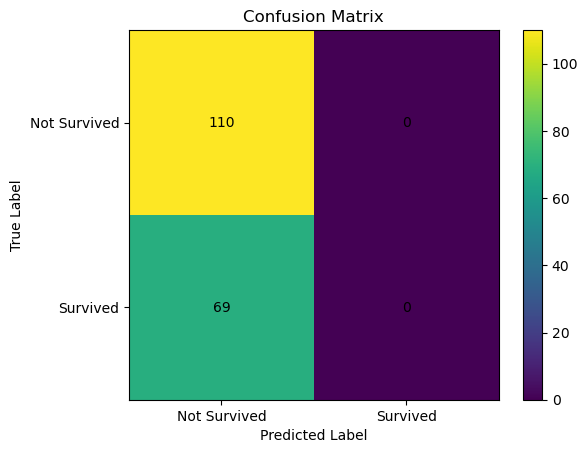

In [18]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Survived', 'Survived'])
plt.yticks(tick_marks, ['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotate each cell with counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 verticalalignment='center')
plt.show()

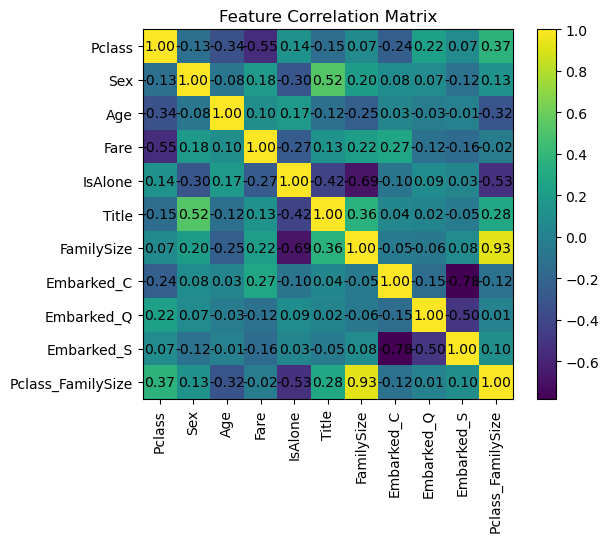

In [19]:
corr_matrix = df_train[features].corr()

plt.figure()
plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Feature Correlation Matrix')
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)

for i in range(len(features)):
    for j in range(len(features)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                 ha="center", va="center")
plt.show()